# Clustering Primer - Episode I

### Context
From the [last blog post](), we saw that data can come with many features. When data gets very complex (at least, more complex than the Starbucks data from the last post), we can rely on machine learning methods to "learn" patterns in the data. For example, suppose you have 1000 photos, of which 500 are cats, and the other 500 are dogs. Machine learning methods can, for instance, read the RGB channels of the images' pixels, then use that information to distinguish which combinations of pixels are associated with cat images, and which combinations are linked to dogs.

Typically, machine learning methods are used for _classification_ - that is, given some data features, such as image pixels, can we say if a photo contains a cat or a dog? Machine learning can also perform _regression_; for example, given Steph Curry's scoring record for the past _n_ games, how many points will he score this coming season? Anyway, for the purposes of this post let's stick to classification.

Even within classification, machine learning methods can be classified as:
* _Supervised_ - that is, we tell our algorithm the "true" labels of our images, or
* _Unsupervised_ - that is, we do not tell our algorithm what the labels are (because sometimes, we don't know!)

The next series of posts will focus on **clustering methods**, which are _unsupervised_ methods. This post will be on **hierarchical clustering**.

### Provisional use case
I have data with lots of features, what groups do they belong to?

### Executive summary
* **30 seconds**: Hierarchical clustering is an unsupervised machine learning method. Users must...
    * Define a way to quantify the distance between data points (e.g. Euclidean distance), and
    * How those distances are leveraged for grouping data, aka the linkage criterion (e.g. use the average distance or maximum distance between hypothetical clusters)
* **8 minutes or more**: Read down below.

In [1]:
# as always, import all the good stuff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist     # pairwise distances
from scipy.cluster.hierarchy import linkage, dendrogram

plt.style.use("ggplot")

Let's get the data, do any cleaning necessary beforehand. We'll do the McDonald's food menu, courtesy of Kaggle.

In [2]:
df = pd.read_csv("../../data/mcdonalds-menu/menu.csv")
df.head()

,Category,Item,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,...,Carbohydrates,Carbohydrates (% Daily Value),Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,...,31,10,4,17,3,17,10,0,25,15
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,...,30,10,4,17,3,18,6,0,25,8
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,...,29,10,4,17,2,14,8,0,25,10
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,...,30,10,4,17,2,21,15,0,30,15
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,...,30,10,4,17,2,21,6,0,25,10


In [3]:
df.columns

Index(['Category', 'Item', 'Serving Size', 'Calories', 'Calories from Fat',
       'Total Fat', 'Total Fat (% Daily Value)', 'Saturated Fat',
       'Saturated Fat (% Daily Value)', 'Trans Fat', 'Cholesterol',
       'Cholesterol (% Daily Value)', 'Sodium', 'Sodium (% Daily Value)',
       'Carbohydrates', 'Carbohydrates (% Daily Value)', 'Dietary Fiber',
       'Dietary Fiber (% Daily Value)', 'Sugars', 'Protein',
       'Vitamin A (% Daily Value)', 'Vitamin C (% Daily Value)',
       'Calcium (% Daily Value)', 'Iron (% Daily Value)'],
      dtype='object')

What is very nice about this dataset (aside from making people hungry) is that the food categories are pre-defined for us. This gives us a nice validation of our clustering methods later on. There are some things we can see here:
* Some columns are redundant (e.g. Saturated Fat + Saturated Fat % daily value)
* Calories are effectively redundant (e.g. calories = sum of nutrients; total fat is related to sat. and trans. fat)
* Some columns are in strings and not numeric (e.g. Serving size)
* Some columns _only_ have % daily value (e.g. Vitamin A) or don't have any (e.g. Sugars)
* Serving sizes of drinks are mixed in with serving size of solid food

For simplicity, let's apply the following normalisation:
* Only use the following items for clustering purposes:
    * Serving size with grams only
    * Saturated Fat, Trans Fat, Cholesterol, Sodium, Carbohydrates, Dietary Fiber, Sugars, Protein
    * Vitamin A (% Daily Value), Vitamin C (% Daily Value), Calcium (% Daily Value), Iron (% Daily Value)
    
* For serving size, use a regex to search out for weight in grams.
* We'll keep Category and Food Item to check what our food items are.

In [4]:
# Define some regex stuff
import re
gramSearch = re.compile('(\d+ g)')
integerSearch = re.compile('\d+')

def regex(string, regexCompiler):
    if not string:
        return None
    
    match = regexCompiler.findall(string)
    
    # We could print an error message
    # if we detect more than 1 or 0 patterns.
    # This is a bit limited if we have a decimal; e.g. 161.1g -> ['161', '1']
    # but let's stick to this for now.
    if not match or len(match) > 1:
        return None
    else:
        return match[0]

In [5]:
# Not clean, but does the job for a one-time implementation.
servingSize = df['Serving Size'].apply(lambda x: regex(x, gramSearch)).copy()
servingSize = servingSize.apply(lambda x: regex(x, integerSearch))
df['Serving Size'] = servingSize

In [6]:
food = df[~pd.isnull(df['Serving Size'])].copy()
food = food[['Category', 'Item', 
       'Serving Size', 'Saturated Fat', 'Trans Fat', 'Cholesterol', 'Sodium',
       'Carbohydrates', 'Dietary Fiber', 'Sugars', 'Protein',
       'Vitamin A (% Daily Value)', 'Vitamin C (% Daily Value)',
       'Calcium (% Daily Value)', 'Iron (% Daily Value)']]

food['Serving Size'] = food['Serving Size'].astype(float)
food.index = list(range(food.shape[0])) # reset the index for convenience

food_names = dict(zip(food.index, food['Item']))
cat_names = dict(zip(food.index, food['Category']))

Okay, this looks good. So in any clustering algorithm, we need to define a distance metric, i.e., how far apart is an `Egg McMuffin` from a `Sausage McMuffin`? One of the most common ways to measure the distance between data points is Euclidean distance, also known as the $l_2$ norm. For two points $a$ and $b$ from $q$-dimensional data, the Euclidean distance is

$$d = \sqrt{\sum_{i=1}^{q} (a_i - b_i) }$$

We can calculate the Euclidean distance between the food items based on the serving size and nutrition values. I chose Euclidean distance because it is the most common distance metric that's used, but others exist (e.g. cosine distance, Manhattan distance... etc. Wikipedia is good for this!)

In [7]:
# Calculate the pairwise distances between items using Euclidean distance
food_values = food[food.columns[2:]].values 
distance_matrix = pdist(food_values, metric = 'euclidean')
distance_matrix.shape

(6903,)

Just a heads-up that the distance matrix calculated by SciPy is a "condensed" matrix. The distance between two points in Euclidean space is the same whether you measure it $a \rightarrow b$ or $b \rightarrow a$, so we only calculate this in one direction. Furthermore, the distance of a point to itself is 0.

Once we have this matrix, then we can apply clustering! Now, we'll use the `scipy` implementation because it natively allows us to visualise dendrograms, and it also doesn't require us to define how many clusters we expect.

From the distance matrix, there are several types of "linkage" criteria we can use. 
The linkage criteria essentially asks, 
> If there are two hypothetical clusters $c_1$ and $c_2$ of sizes $n$ and $m$, do we use the minimum, maximum, or average distances between the points?

The cluster with the **lowest** minimum/maximum/average distance is then merged to the current cluster.
>The Wikipedia page on [Complete clustering](https://en.wikipedia.org/wiki/Complete-linkage_clustering#First_step) explains the algorithm well. 

Note that the choice of the distance metric and linkage criteria can affect the results substantially. For this exercise, I will only use Euclidean distance, but will cycle through the different linkage criteria.

In [8]:
# UPGMA, or average linkage
UPGMA = linkage(distance_matrix, 'average')

Done! You've now run a UPGMA on the distance matrix. We can see the results of the clustering in a tree-like visualisation called a dendrogram:

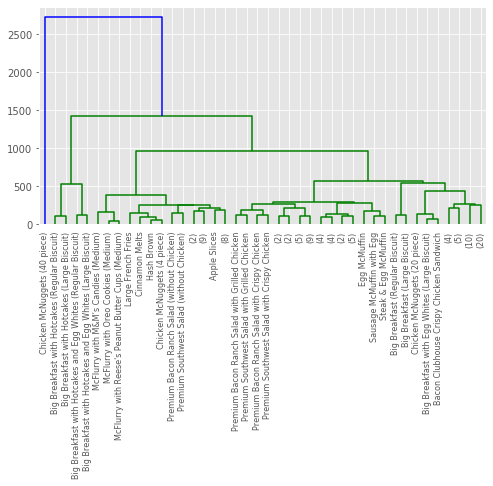

In [9]:
dend_upgma = dendrogram(UPGMA, p = 7, truncate_mode='level')
fig = plt.gcf()
ax = plt.gca()

# Plot the dendrogram based on the name of the food item
new_ticklabels = [ t.get_text() if "(" in t.get_text() else food_names[int(t.get_text())] for t in ax.get_xticklabels() ]
ax.set_xticklabels(new_ticklabels, rotation = 90)

fig.set_size_inches((8,4))

For the dendrogram, to avoid having too many labels that are too small to read, I've only plotted the top 7 levels. Anything in brackets is essentially saying that there are, say, 20 items in that branch.

The dendrogram shows how objects are grouped together, and whether there are any singletons. The height of the dendrogram corresponds to the distance between objects.

We can already see patterns; for instance, premium salads with chicken group together, while those without chicken go elsewhere. Likewise, the breakfast items are also grouping together. We can run clustering again with a different linkage criteria, such as complete linkage:

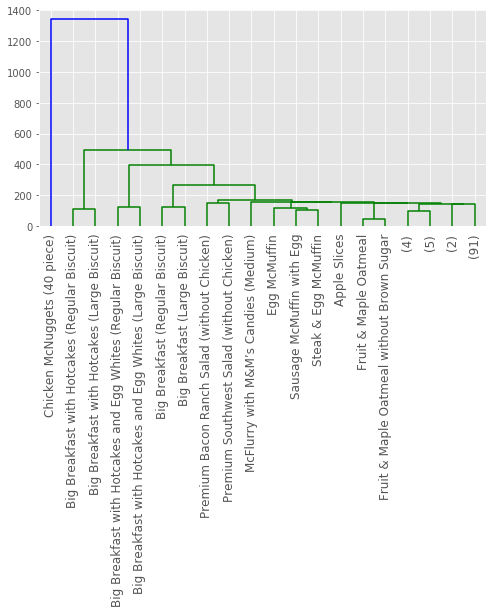

In [10]:
single = linkage(distance_matrix, method='single')
dend = dendrogram(single, p = 10, truncate_mode='level')
fig = plt.gcf()
ax = plt.gca()

# Plot the dendrogram based on the name of the food item
new_ticklabels = [ t.get_text() if "(" in t.get_text() else food_names[int(t.get_text())] for t in ax.get_xticklabels() ]
ax.set_xticklabels(new_ticklabels, rotation = 90)

fig.set_size_inches((8,4))

Now with Ward clustering:

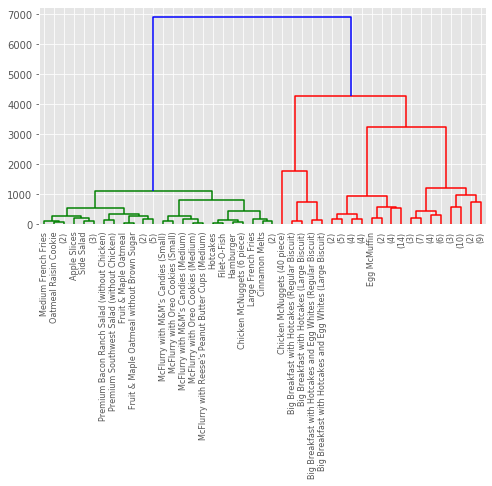

In [11]:
ward = linkage(distance_matrix, method='ward')
dend = dendrogram(ward, p = 5, truncate_mode='level')
fig = plt.gcf()
ax = plt.gca()

# Plot the dendrogram based on the name of the food item
new_ticklabels = [ t.get_text() if "(" in t.get_text() else food_names[int(t.get_text())] for t in ax.get_xticklabels() ]
ax.set_xticklabels(new_ticklabels, rotation = 90)

fig.set_size_inches((8,4))

So while we have some common patterns, it's clear that different linkage criteria affect the clustering results, leading to the different dendrograms. None of these are necessarily better than the other; they are just alternative ways to cluster your data. In fact, the linkage criterion that you end up choosing should largely depend on your data distribution; see [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html) for an example.

### Bonus visualisation
As an additional visualisation, we can also apply principal component analysis (PCA) on the data, then colour the points according to their cluster membership.

In [12]:
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

pca = PCA(n_components = 2) # we already have a distance matrix
coords = pca.fit_transform(food_values - food_values.mean()) # remember to scale the data

# Let's use the actual categories from McDonald's as a "true" set of labels
categories = food['Category']
cat_to_int = dict([ (label,i) for i, label in enumerate(set(categories)) ])

# Here, we can choose an arbitrary number of clusters to visualise.
# Since we have the categories from McDonald's, we can use this for
# visualisation purposes.
num_clust = len(set(categories))

# Let's use Ward clustering, because, why not.
ac = AgglomerativeClustering(n_clusters = num_clust, linkage= 'ward')
ac.fit(food[food.columns[2:]].values)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=7,
                        pooling_func='deprecated')

Text(0.5, 1.0, 'True categories')

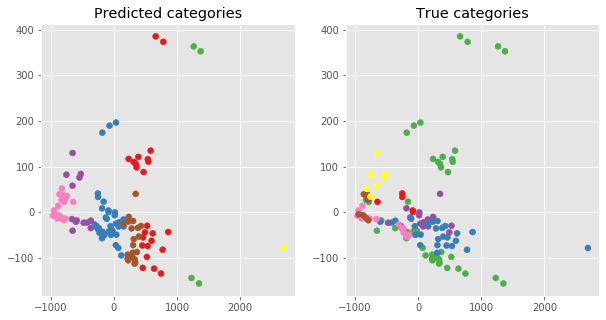

In [13]:
# map labels to colour palette - choose something that's discrete to allow easier colour disambiguation.
cm = plt.get_cmap("Set1")

# Here, we first get a numpy array of evenly-spaced values between 0 and 1
# Then we map each float to an RGB value using the ColorMap above.
# The RGBA values are then mapped to integers, as sklearn's labels are integers.
# i.e. this will look like 
# {0: (r,g,b,a), 1: (r1, g1, b1, a1)... etc.}

mapped = dict([ (i, cm(v)) for i,v in enumerate(np.arange(0, 1.01, 1./num_clust)) ])


# plot the PCA and colour with our predicted cluster, and the categories from the McDonald's menu as a comparison
fig, ax = plt.subplots(1,2)
ax[0].scatter(coords[:,0], coords[:,1],
           color = [ mapped[label] for label in ac.labels_ ])

ax[1].scatter(coords[:,0], coords[:,1],
           color = [ mapped[cat_to_int[name]] for name in food['Category'] ])

fig.set_size_inches((10,5))
ax[0].set_title("Predicted categories")
ax[1].set_title("True categories")

Interpreting this plot may be difficult, but essentially, it would be ideal to have the same set of points in both the left-hand and right-hand plots to share a colour. In other words, the points that are red don't necessarily have to be red in the right-hand plot, but those same points should hopefully share one colour (whether it's blue, pink, or whatever).

We see that this isn't the case - so what then? This means that we'd have to do a more careful look into what categories the food items belong to, and question more carefully on what the "true" categories are here. Essentially, the categories are only designating whether a food item is something you have for breakfast, or it contains fish, etc. However, we've clustered the data on the basis of their nutrition. The "true" cluster membership is, in hindsight, not well-aligned to what we had clustered the data with. (i.e. nutrition profiles alone don't tell you whether something is a breakfast item vs. a fish burger).

Earlier, we saw in the dendrograms that individually similar food items _did_ cluster together (e.g. the different flavours of salads), so we know that there is some information of use here. However, grouping food items into larger categories may not be as intuitive. 

Nonetheless, I hope this was a useful session on what clustering can offer you. 